# Collision Rate Calculation

In [18]:
!date

Sun Oct 20 15:52:38 PDT 2024


In [2]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/scquint_4'

In [56]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats




In [4]:
import sys
import os
import glob

In [5]:
#prenatal samples

# barcodes = pd.read_csv('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/GW23_1_barcodes.csv',header=None)

# input_dir = '/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/processing/'

# output_dir = '/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/'

In [6]:
output_dir = '/c4/home/derek/data1/derek/data_scSLR/PBMC/'

samples = [
    'sample_1', 
    'sample_2'
]

In [7]:
%%time 

barcodes = {}
collision_tables = {}



for sample in samples:
    
    barcodes[sample] = pd.read_csv(f'/c4/home/derek/data1/derek/data_scSLR/PBMC/PBMC_{sample}_idents.csv',header=None,sep='\t')

    input_dir = f'/c4/home/derek/data1/derek/data_scSLR/immune_fastqs/{sample}/split/'

    collision_tables[sample] = pd.DataFrame()
    
    for file in os.listdir(input_dir):
        if file.endswith('collision_table.csv'):
            print(file)
            
            
            df = pd.read_csv(input_dir+file, index_col=0)

            #remove non gene aligned reads 
            df = df[df['gene_ID'] != '-']

            ##remove polyG beads
            df = df[df['bead_ID'] != 1]

            #include only reads aligning to cells
            df = df[df.cell.isin(barcodes[sample][0])]

            #get per-gene values
            df = df.groupby('gene_ID')['collision'].value_counts(normalize=True).unstack().fillna(0)

            #remove index name
            df = df.rename_axis(None, axis=1)

            collision_tables[sample] = pd.concat([collision_tables[sample],df])

            del df 
            print(file+" processed")
        else:
            pass


    
    

chrY.barcoded.sort.bam_collision_table.csv
chrY.barcoded.sort.bam_collision_table.csv processed
chr18.barcoded.sort.bam_collision_table.csv
chr18.barcoded.sort.bam_collision_table.csv processed
chr19.barcoded.sort.bam_collision_table.csv
chr19.barcoded.sort.bam_collision_table.csv processed
chr12.barcoded.sort.bam_collision_table.csv
chr12.barcoded.sort.bam_collision_table.csv processed
chr6.barcoded.sort.bam_collision_table.csv
chr6.barcoded.sort.bam_collision_table.csv processed
chr9.barcoded.sort.bam_collision_table.csv
chr9.barcoded.sort.bam_collision_table.csv processed
chr20.barcoded.sort.bam_collision_table.csv
chr20.barcoded.sort.bam_collision_table.csv processed
chr13.barcoded.sort.bam_collision_table.csv
chr13.barcoded.sort.bam_collision_table.csv processed
chr22.barcoded.sort.bam_collision_table.csv
chr22.barcoded.sort.bam_collision_table.csv processed
chr14.barcoded.sort.bam_collision_table.csv
chr14.barcoded.sort.bam_collision_table.csv processed
chr17.barcoded.sort.bam_co

In [8]:
# collision_tables['sample_1'] = collision_tables['sample_1_rerun']
# del collision_tables['sample_1_rerun']

# barcodes['sample_1'] = barcodes['sample_1_rerun']
# del barcodes['sample_1_rerun']

In [9]:
#collision_tables[sample] = collision_tables[sample][~collision_tables[sample].index.str.startswith('__')]

In [19]:
# check scatter

ct_1= collision_tables['sample_1']
ct_2= collision_tables['sample_2']

ct_1.index.name = None
ct_2.index.name = None

ct_1 = ct_1[~ct_1.index.str.startswith('__')]
ct_2 = ct_2[~ct_2.index.str.startswith('__')]

ct_1 = ct_1[ct_1.index.isin(ct_2.index)]
ct_2 = ct_2[ct_2.index.isin(ct_1.index)]

ct_2= ct_2.reindex(ct_1.index)

In [20]:
pd.testing.assert_index_equal(ct_1.index,
                              ct_2.index,
                             )


(-0.001, 1.0)

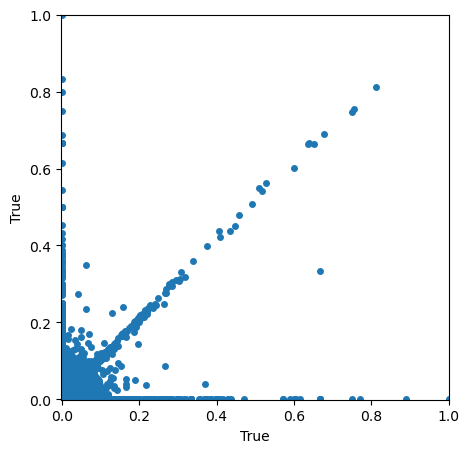

In [21]:
fig, ax = plt.subplots(1,1,figsize = (5,5))

sns.scatterplot(x=ct_1[True],
                y=ct_2[True], 
                ax=ax,
                s=25, 
                linewidth =0
               )

ax.set_xlim(-0.001,1)
ax.set_ylim(-0.001,1)

In [22]:
import scanpy as sc

In [23]:
sc_input_dir = '/c4/home/derek/data1/derek/data_scSLR/PBMC/STAR_outs/'# sample_1/StarOut_merged/Solo.out/GeneFull/raw/'


In [28]:
# .reindex(df_HVG_.index)

In [29]:
# collision_tables[sample][collision_tables[sample].index.isin(df_HVG_.index)]

In [30]:
# pd.Series(df_HVG_.index.duplicated()).value_counts()

In [27]:
%%time
adatas = {}

dfs_collisions = {}

samples = ['sample_1',
           'sample_2'
          ]

for sample in samples:
    sample_dir = sc_input_dir+sample+'/StarOut_merged/Solo.out/GeneFull/raw/'

    adatas[sample] = sc.read_mtx(sample_dir + 'matrix.mtx').T
    adatas[sample].obs_names = pd.read_csv(sample_dir+'barcodes.tsv',header=None)[0]
    adatas[sample].var_names = pd.read_csv(sample_dir+'features.tsv',header=None,sep='\t')[0]
    
    adatas[sample].var_names_make_unique()

    adatas[sample]=adatas[sample][adatas[sample].obs_names.isin(barcodes[sample][0])]

    sc.pp.normalize_total(adatas[sample], target_sum=1e4)
    sc.pp.log1p(adatas[sample])
    
    df_HVG = sc.pp.highly_variable_genes(adatas[sample], min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=False)
    ID_dict = dict(zip(pd.read_csv(sample_dir+'features.tsv',header=None,sep='\t')[0],
         pd.read_csv(sample_dir+'features.tsv',header=None,sep='\t')[1])
        )
    
    df_HVG.index = adatas[sample].var_names 
    df_HVG['gene_name'] = df_HVG.index.map(ID_dict)
    
    df_HVG_ = df_HVG[df_HVG.index.isin(collision_tables[sample].index)]
    #collision_tables[sample] = collision_tables[sample].reindex(df_HVG_.index)
    
    collision_tables[sample] = collision_tables[sample][collision_tables[sample].index.isin(df_HVG_.index)]
    # collision_tables[sample].rename_axis(None, axis=1)
    
    
    
    dfs_collisions[sample] = pd.concat([df_HVG_,collision_tables[sample]],axis=1)
    dfs_collisions[sample].columns = ['means','dispersions','mean_bin','dispersions_norm', 'highly_variable','gene_name','False_rate','True_rate']
    dfs_collisions[sample] = dfs_collisions[sample].sort_values(by='True_rate')

    

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 1min 41s, sys: 1.35 s, total: 1min 43s
Wall time: 1min 45s


<Axes: xlabel='True_rate', ylabel='True_rate'>

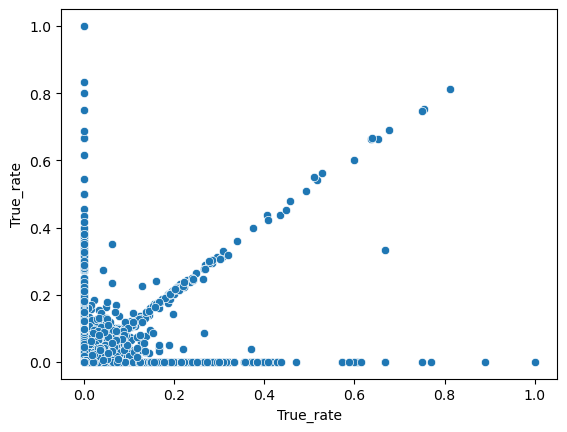

In [31]:
sns.scatterplot(
x=dfs_collisions['sample_1']['True_rate'],
y=dfs_collisions['sample_2']['True_rate']
)

In [32]:
collisions_Scatter = pd.concat([
    dfs_collisions['sample_1']['True_rate'],
    dfs_collisions['sample_2']['True_rate']],
    axis=1,
    join='inner', 
)
collisions_Scatter.columns = ['sample_1','sample_2']

<Axes: xlabel='sample_1', ylabel='sample_2'>

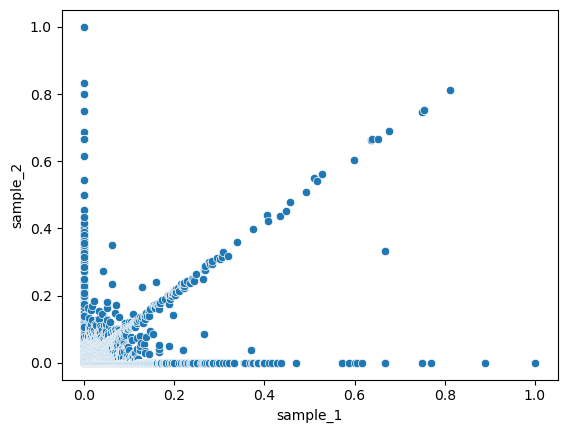

In [33]:
sns.scatterplot(collisions_Scatter, 
               x='sample_1',
               y='sample_2')

In [34]:
collisions_Scatter['mean_expression_sample1'] =  dfs_collisions['sample_1'].reindex(collisions_Scatter.index)['means']
collisions_Scatter['mean_expression_sample2'] =  dfs_collisions['sample_2'].reindex(collisions_Scatter.index)['means']

collisions_Scatter['gene_name'] =  dfs_collisions['sample_1'].reindex(collisions_Scatter.index)['gene_name']

In [35]:
collisions_Scatter = collisions_Scatter.sort_values(by='sample_2')

In [36]:
#temp_ = temp[(temp['sample_1'] > 0) & (temp['sample_2'] > 0)]
collisions_Scatter_ = collisions_Scatter[(collisions_Scatter['mean_expression_sample1'] > 1.0e-5) & (collisions_Scatter['mean_expression_sample2'] > 1.0e-5)]

In [37]:
print(collisions_Scatter_.shape)
print(collisions_Scatter_.shape)

(20378, 5)
(20378, 5)


In [38]:
%%time
corr = stats.pearsonr(x=collisions_Scatter_['sample_1'],
                        y=collisions_Scatter_['sample_2']          
                     )

corr

CPU times: user 184 ms, sys: 510 ms, total: 694 ms
Wall time: 33.5 ms


PearsonRResult(statistic=0.4324278251938667, pvalue=0.0)

In [39]:
np.mean([collisions_Scatter_['mean_expression_sample1'],collisions_Scatter_['mean_expression_sample2']],axis=0)

array([2.94727905e-04, 4.47264979e-04, 8.58550796e-04, ...,
       1.79406439e-01, 2.60066823e+00, 2.49241835e-03])

Text(0, 0.5, 'mean percent collisions \n scSLR-seq rep 2.')

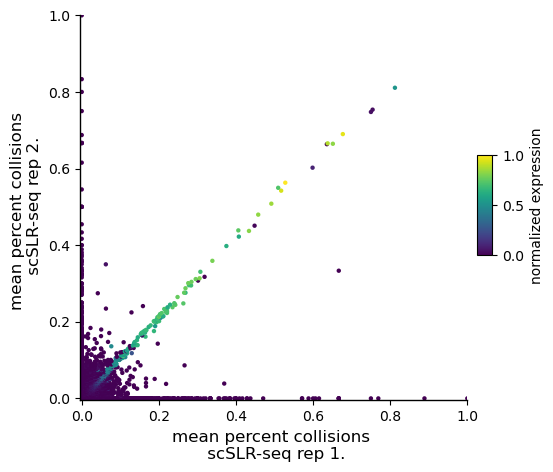

In [40]:
fig, ax = plt.subplots(1,1,figsize = (5,5))

n = sns.scatterplot(data=collisions_Scatter, 
                x='sample_1',
                y='sample_2', 
                hue=np.mean([collisions_Scatter['mean_expression_sample1'],collisions_Scatter['mean_expression_sample2']],axis=0),
                ax=ax,
                s=10, 
                linewidth =0, 
                palette='viridis'
               )


# for line in range((temp.sort_values(by ='sample_1',ascending=True).shape[0]-100),
#                   temp.sort_values(by ='sample_1',ascending=True).shape[0]
#                  ):
    
#     n.text(x=temp.sort_values(by ='mean_expression_sample1',ascending=True).sample_1[line]+0.01,
#            y=temp.sort_values(by ='mean_expression_sample1',ascending=True).sample_2[line], 
#              s = temp.sort_values(by ='sample_1',ascending=True).gene_name[line],
#              horizontalalignment='left', 
             
#              size='medium', 
#              color='black', 
#              # weight='semibold'
#             )


norm = plt.Normalize(collisions_Scatter['sample_1'].min(), 
                     collisions_Scatter['sample_2'].max())

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.92, 0.4, 0.03, 0.2])


fig.colorbar(sm, cax=cbar_ax, label='normalized expression')

ax.get_legend().remove()

ax.set_xlim(-0.005,1)
ax.set_ylim(-0.005,1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.spines.bottom.set_linewidth(1)
ax.spines.left.set_linewidth(1)

ax.set_xlabel('mean percent collisions \n scSLR-seq rep 1.',fontsize=12)
ax.set_ylabel('mean percent collisions \n scSLR-seq rep 2.',fontsize=12)

# fig.savefig('./plots/collision_rate_corr.pdf')

# Plot single sample metrics 

In [41]:
df_collisions = dfs_collisions['sample_1']#.reindex(temp.index)

In [42]:
lengths_transcripts = pd.read_csv('/c4/home/derek/data1/derek/reference/human_hp3_reference/genes.gtf.genelength',sep='\t',
                                 index_col=0)

In [43]:
lengths_transcripts = lengths_transcripts[lengths_transcripts.index.isin(df_collisions.index)]

In [44]:
df_collisions = df_collisions[df_collisions.index.isin(lengths_transcripts.index)]

In [45]:
df_collisions

,means,dispersions,mean_bin,dispersions_norm,highly_variable,gene_name,False_rate,True_rate
ENSG00000243485,2.028295e-04,0.756087,"(-0.005, 0.25]",-1.405559,False,MIR1302-2HG,1.000000,0.000000
ENSG00000255171,1.725513e-03,1.269874,"(-0.005, 0.25]",-0.176618,False,LINC01499,1.000000,0.000000
ENSG00000255279,1.000000e-12,NaN,"(-0.005, 0.25]",0.000000,False,AC023442.3,1.000000,0.000000
ENSG00000255300,1.897552e-03,1.532515,"(-0.005, 0.25]",0.451599,False,LINC02745,1.000000,0.000000
ENSG00000255109,9.801707e-04,1.366111,"(-0.005, 0.25]",0.053573,False,LINC02740,1.000000,0.000000
...,...,...,...,...,...,...,...,...
ENSG00000244734,2.605880e+00,2.856075,"(2.498, 2.748]",0.671858,True,HBB,0.187689,0.812311
ENSG00000182459,2.572889e-04,0.509358,"(-0.005, 0.25]",-1.995716,False,TEX19,0.111111,0.888889
ENSG00000274248,3.542456e-04,1.313788,"(-0.005, 0.25]",-0.071581,False,AJ011932.1,0.000000,1.000000
ENSG00000274918,6.497162e-04,1.227671,"(-0.005, 0.25]",-0.277566,False,AC116447.1,0.000000,1.000000


In [46]:
lengths_transcripts = lengths_transcripts.reindex(df_collisions.index)

In [47]:
df_collisions['length_mean'] = lengths_transcripts['mean']
df_collisions['length_median'] = lengths_transcripts['median']
df_collisions['length_longest_isoform'] = lengths_transcripts['longest_isoform']
df_collisions['length_merged'] = lengths_transcripts['merged']

/scratch/derek/ipykernel_1149726/3327041963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collisions['length_mean'] = lengths_transcripts['mean']
/scratch/derek/ipykernel_1149726/3327041963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collisions['length_median'] = lengths_transcripts['median']
/scratch/derek/ipykernel_1149726/3327041963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [48]:
df_collisions['True_clipped'] = df_collisions['True_rate'].clip(upper=0.1)

/scratch/derek/ipykernel_1149726/779766503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collisions['True_clipped'] = df_collisions['True_rate'].clip(upper=0.1)


In [49]:
df_collisions = df_collisions.sort_index()

In [50]:
# from matplotlib.colors import LinearSegmentedColormap


In [60]:
cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

In [61]:
parula_map = mpl.colors.LinearSegmentedColormap.from_list('parula', cm_data)

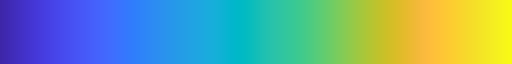

In [88]:
parula_map

In [111]:
SAMPLES=256

protland = px.colors.sample_colorscale(px.colors.diverging.Portland, 256, low=0.2, high=1)
rgb = [px.colors.unconvert_from_RGB_255(px.colors.unlabel_rgb(c)) for c in protland]

portland_map = mpl.colors.ListedColormap(rgb, name='Portland', N=256)

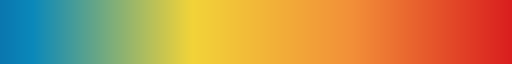

In [112]:
portland_map

/scratch/derek/ipykernel_1149726/364012772.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['-1','0','1','2','3','4','5'],fontsize=12)
/scratch/derek/ipykernel_1149726/364012772.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(['0','1','2','3','4','5'], fontsize=12)


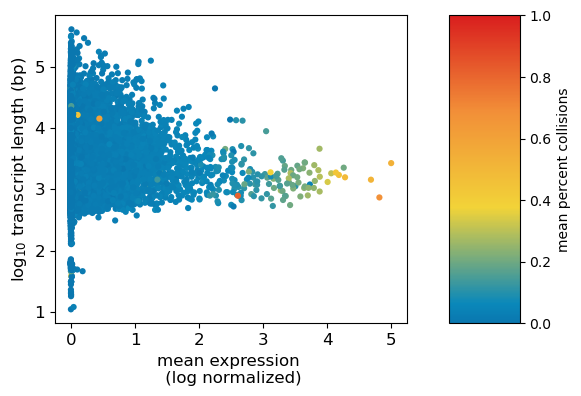

In [121]:
plt.rcParams['figure.figsize'] = 6,4
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios':[5,1]})

cmap = portland_map

sm = sns.scatterplot(data=df_collisions.sort_values(by ='True_rate',ascending=True),
                x=df_collisions.means, 
                y=np.log10(df_collisions.length_median),
                s=20,
                linewidth=0,
                hue=df_collisions.True_rate,
                palette=cmap,
                alpha=1,
                ax=ax[0],
               )



norm = plt.Normalize(df_collisions['True_rate'].min(), df_collisions['True_rate'].max())
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])

ax[0].get_legend().remove()

fig.figure.colorbar(sm,shrink=.25,aspect=6,
                     #orientation='horizontal',
                     label='mean percent collisions',
                     cax=ax[1]
                     )

# axes.spines.right.set_visible(False)
# axes.spines.top.set_visible(False)

# axes.spines.bottom.set_linewidth(1)
# axes.spines.left.set_linewidth(1)

ax[0].set_xlabel('mean expression \n (log normalized)',fontsize=12)
ax[0].set_ylabel('log$_{10}$ transcript length (bp)',fontsize=12)

ax[0].set_xticklabels(['-1','0','1','2','3','4','5'],fontsize=12)
ax[0].set_yticklabels(['0','1','2','3','4','5'], fontsize=12)


fig.savefig('plots/collision_rates_length_2.pdf')

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

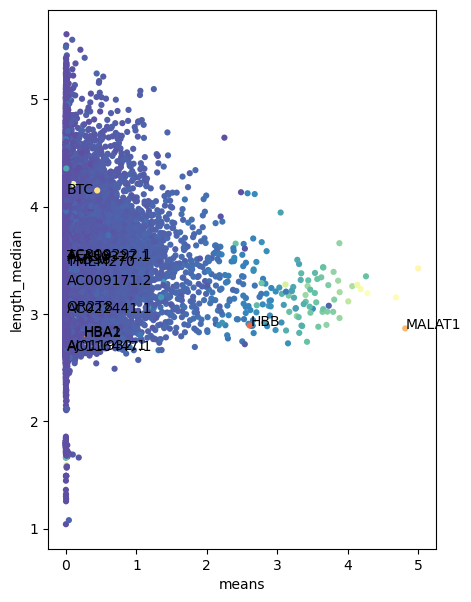

In [115]:
fig, axes = plt.subplots(1,1, figsize = (5,7))

sm = sns.scatterplot(data=df_collisions.sort_values(by ='True_rate',ascending=True),
                x=df_collisions.means, 
                y=np.log10(df_collisions.length_median),
                s=20,
                linewidth=0,
                hue=df_collisions.True_rate,
                palette='Spectral_r',
                alpha=1,
                ax=axes,
               )



### make point labels ####


for line in range((df_collisions.sort_values(by ='True_rate',ascending=True).shape[0]-15),
                  df_collisions.sort_values(by ='True_rate',ascending=True).shape[0]
                 ):
    
    sm.text(x=df_collisions.sort_values(by ='True_rate',ascending=True).means[line]+0.01,
             y=np.log10(df_collisions.sort_values(by ='True_rate',ascending=True).length_median[line]), 
             s = df_collisions.sort_values(by ='True_rate',ascending=True).gene_name[line],
             horizontalalignment='left', 
             
             size='medium', 
             color='black', 
             # weight='semibold'
            )
    

### make colorbar ####

    
norm = plt.Normalize(df_collisions['True_rate'].min(), df_collisions['True_rate'].max())
sm = plt.cm.ScalarMappable(cmap="Spectral_r",norm=norm)
sm.set_array([])



### format Axes ####

axes.get_legend().remove()
axes.figure.colorbar(sm,shrink=.25,aspect=6,
                     orientation='horizontal',
                     label='mean percent collisions')



axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

axes.spines.bottom.set_linewidth(1)
axes.spines.left.set_linewidth(1)


axes.set_xlabel('mean expression \n (log normalized)',fontsize=12)
axes.set_ylabel('log$_{10}$ transcript length (bp)',fontsize=12)

axes.set_xticklabels(['-1','0','1','2','3','4','5'],fontsize=12)
axes.set_yticklabels(['0','1','2','3','4','5'], fontsize=12)


# fig.savefig('./plots/collision_rates_length.pdf')

In [ ]:
df_collisions[df_collisions.gene_name == 'MALAT1']

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

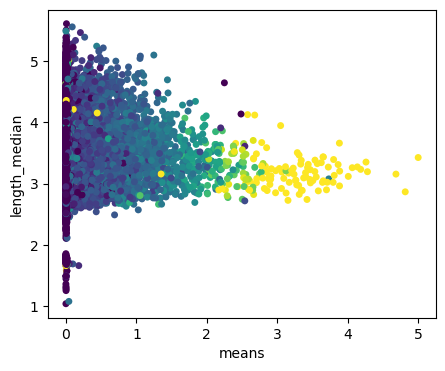

In [116]:
plt.rcParams['figure.figsize'] = 5,4
fig, axes = plt.subplots(1,1)

sm = sns.scatterplot(data=df_collisions,
                x=df_collisions.means, 
                y=np.log10(df_collisions.length_median),
                s=25,
                linewidth=0,
                hue=df_collisions.True_clipped,
                palette='viridis',
                alpha=1,
                ax=axes,
               )



norm = plt.Normalize(df_collisions['True_clipped'].min(), df_collisions['True_clipped'].max())
sm = plt.cm.ScalarMappable(cmap='viridis',norm=norm)
sm.set_array([])


axes.get_legend().remove()
axes.figure.colorbar(sm,shrink=.25,aspect=6,
                    # orientation='horizontal',
                     label='mean percent collisions',
                    extend='max',
                     extendfrac=.2
                    )

# axes.spines.right.set_visible(False)
# axes.spines.top.set_visible(False)

# axes.spines.bottom.set_linewidth(1)
# axes.spines.left.set_linewidth(1)

axes.set_xlabel('mean expression \n (normalized)')
axes.set_ylabel('log$_{10}$ transcript length (bp)')

In [ ]:
collision_table_sample1 = pd.read_csv(output_dir+'sample_1_collisions_table.csv',index_col=0)

collision_table_sample1_adj= pd.read_csv(output_dir+'collision_table_sample1_adj2',index_col=0)


collision_table_sample1 = collision_table_sample1[collision_table_sample1.index.isin(collision_table_sample1_adj.index)]

collision_table_sample1_adj = collision_table_sample1_adj[collision_table_sample1_adj.index.isin(collision_table_sample1.index)]



In [ ]:
collision_table_sample1['True']

In [ ]:
collision_table_sample1_adj[collision_table_sample1_adj.index.isin(collision_table_sample1.index)]

In [ ]:
collision_table_sample1[collision_table_sample1.index.isin(collision_table_sample1_adj.index)]

In [ ]:
collision_table_sample1_adj[collision_table_sample1_adj.index.isin(collision_table_sample1.index)]

In [ ]:
df_collisions_ = df_collisions[df_collisions.index.isin(collision_table_sample1.index)]
df_collisions_ = df_collisions_.reindex(collision_table_sample1.index)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(x=collision_table_sample1['True'],
                y=collision_table_sample1_adj['True'],
                ax=ax,
                linewidth = 0,
                size=5,
                # hue = df_collisions_.means
               )

In [ ]:
df = pd.concat([collision_table_sample1['True'], collision_table_sample1_adj['True']], axis=1)
df.columns = ['sample_1','sample_1_adj']

In [ ]:
df['exp'] = df_collisions_.means

In [ ]:
df.exp.sort_values().tai

In [ ]:
df.loc['ENSG00000251562']

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(data = df,
                x='sample_1',
                y='sample_1_adj',
                ax=ax,
                linewidth = 0,
                size=20,
                hue='exp',
                # alpha=0.2,
                palette='plasma',
               )

In [ ]:
input_dir='/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/'

In [ ]:

residuals=pd.read_csv(input_dir+'correlation_residuals.csv',header=None,index_col=0)
residuals.columns = ['residual']

In [ ]:
df_collisions = df_collisions.join(residuals)

In [ ]:
plt.rcParams['figure.figsize'] = 5,4
fig, axes = plt.subplots(1,1)

sm = sns.scatterplot(data=df_collisions.sort_values(by ='True_rate',ascending=True),
                x=df_collisions.sort_values(by ='True_rate',ascending=True).means, 
                y=df_collisions.sort_values(by ='True_rate',ascending=True).dispersions,
                s=5,
                linewidth=0,
                hue=df_collisions.sort_values(by ='True_rate',ascending=True).residual,
                palette='Spectral_r',
                alpha=1,
                ax=axes,
               )



norm = plt.Normalize(df_collisions['True_rate'].min(), df_collisions['True_rate'].max())
sm = plt.cm.ScalarMappable(cmap="Spectral_r",norm=norm)
sm.set_array([])


axes.get_legend().remove()
axes.figure.colorbar(sm,shrink=.25,aspect=6,
                    # orientation='horizontal',
                     label='mean percent collisions')

# axes.spines.right.set_visible(False)
# axes.spines.top.set_visible(False)

# axes.spines.bottom.set_linewidth(1)
# axes.spines.left.set_linewidth(1)

axes.set_xlabel('mean expression \n (normalized)')
axes.set_ylabel('Dispersion')

#fig.savefig('collision_rates.pdf')

In [ ]:
plt.rcParams['figure.figsize'] = 5,4
fig, axes = plt.subplots(1,1)

sm = sns.scatterplot(data=df_collisions,
                x=df_collisions.means, 
                y=df_collisions.True_rate,
                s=15,
                linewidth=0,
              #  hue=df_collisions.True_rate,
              #  palette='Spectral_r',
                alpha=1,
                ax=axes,
               )



#norm = plt.Normalize(df_collisions['True_rate'].min(), df_collisions['True_rate'].max())
# sm = plt.cm.ScalarMappable(cmap="Spectral_r",norm=norm)
# sm.set_array([])


#axes.get_legend().remove()
axes.figure.colorbar(sm,shrink=.25,aspect=6,
                    # orientation='horizontal',
                     label='mean percent collisions')

# axes.spines.right.set_visible(False)
# axes.spines.top.set_visible(False)

# axes.spines.bottom.set_linewidth(1)
# axes.spines.left.set_linewidth(1)

axes.set_xlabel('mean expression \n (normalized)')
axes.set_ylabel('Dispersion')

#fig.savefig('collision_rates.pdf')

In [ ]:
df_collisions[df_collisions.True_rate > .5]

In [ ]:
plt.rcParams['figure.figsize'] = 5,4
fig, axes = plt.subplots(1,1)

sm = sns.scatterplot(data=df_collisions,
                x=df_collisions.means, 
                y=df_collisions.dispersions,
                s=10,
                linewidth=0,
                hue=df_collisions.True_clipped,
                palette='viridis',
                alpha=1,
                ax=axes,
               )

norm = plt.Normalize(df_collisions['True_clipped'].min(), df_collisions['True_clipped'].max())
sm = plt.cm.ScalarMappable(cmap="viridis",norm=norm)
sm.set_array([])


axes.get_legend().remove()
axes.figure.colorbar(sm,shrink=.25,aspect=4,
                    # orientation='horizontal',
                     label='mean percent collisions \n 0.1 clipped')

# axes.spines.right.set_visible(False)
# axes.spines.top.set_visible(False)

# axes.spines.bottom.set_linewidth(1)
# axes.spines.left.set_linewidth(1)

axes.set_xlabel('mean expression \n (normalized)')
axes.set_ylabel('Dispersion')


In [ ]:
%%time
collision_table = pd.DataFrame()

for file in os.listdir(input_dir):
    df = pd.read_csv(input_dir+file, index_col=0)
    
    #remove non gene aligned reads 
    df = df[df['gene_ID'] != '-']
    
    ##remove polyG beads
    df = df[df['bead_ID'] != 1]
    
    #include only reads aligning to cells
    df = df[df.cell.isin(barcodes[0])]
    
    #get per-gene values
    df = df.groupby('gene_ID')['collision'].value_counts(normalize=True).unstack().fillna(0)
    
    #remove index name
    df = df.rename_axis(None, axis=1)
    
    collision_table = pd.concat([collision_table,df])
    
    del df 
    print(file+" processed")

In [ ]:
df = pd.read_csv(input_dir+file, index_col=0)

In [ ]:
df

In [ ]:
df = df[df['gene_ID'] != '-']

In [ ]:
df = df[df['bead_ID'] != 1]

In [ ]:
df = df[df['UMI'] != '-']

In [ ]:
df['bead_ID'] = df['bead_ID'].astype(str)

In [ ]:
temp = df.groupby(['gene_ID','UMI','cell'])['bead_ID'].nunique()

In [ ]:
temp
temp.index = temp.index.map('_'.join)

In [ ]:
temp.value_counts().to_frame().sum()

In [ ]:
temp.value_counts()

In [ ]:
(283853-102672)/283853

In [ ]:
sns.barplot(np.log10(temp.value_counts()).to_frame().T)

In [ ]:
sns.barplot(temp.value_counts().to_frame().T)

In [ ]:
df

In [ ]:
!conda list